Os templates HTML foram modificados para apresentação com base nesse [artigo](https://medium.com/star-gazers/building-churn-predictor-with-python-flask-html-and-css-fbab760e8441)

Os templates utilizados são do [Multi Boostrap Template](https://bootstrapmade.com/multi-responsive-bootstrap-template/)

In [31]:
import math
import datetime 
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score
from IPython.core.display import HTML
from IPython.display import Image
import gc
import dataframe_image as dfi
import warnings
warnings.filterwarnings("ignore")

## 0.1. Funções Auxiliares

In [32]:
def load_csv(path):
    ''' Função utilizada para carregamento dos dados'''
    df = pd.read_csv(path, low_memory=True)
    return df
    
def show_dimensions(df):
    ''' Função utilizada para obter as dimensões dos dados'''
    print(f"Number of Rows:    {df.shape[0]}")
    print(f"Number of Columns: {df.shape[1]}")
    print(f"Shape:             {df.shape}")
    return None

def show_data_types(df):
    ''' Função utilizada para obter os tipos dos dados'''
    print(df.dtypes)
    return None

def check_na(df):
    ''' Função utilizada para visualizar dados ausentes ou NaN'''
    df_aux = pd.DataFrame(df.isna().sum().sort_values(ascending=False),columns=['Quantity of Missings'])
    size = df.shape[0]
    df_aux['Percent of Missings'] = 100*df_aux/size    
    df_aux = df_aux.sort_values(by='Percent of Missings',ascending=False)
    return df_aux

def eliminate_incorrect_entries_code_gender(df):
    ''' Função utilizada para eliminar as entradas incorretas (XNA) na variável CODE_GENDER'''
    df = df[df['CODE_GENDER'] != 'XNA']
    return df
    
def change_to_binary(df,columns):
    ''' Função utilizada para tornar as variáveis especificadas como binárias'''
    for bin_feature in columns:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    return df

def show_descriptive_statistical(df):
    ''' Função utilizada para exibir informações de estatística descritiva'''
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    df_descriptive = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    df_descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return df_descriptive

def drop_id_column(df):
    ''' Função utilizada para dropar a coluna ID'''
    df.drop(columns=['SK_ID_CURR'],inplace=True)
    return df

def one_hot_encoder(df, nan_as_category = True):
    original_columns    = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df                  = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns         = [column for column in df.columns if column not in original_columns]
    return df, new_columns

def numeric_category_dataframe(df):
    numeric_columns     = df.describe().columns.to_list()
    category_columns    = df.drop(columns=numeric_columns).columns
    numeric_dataframe   = df[numeric_columns]
    category_dataframe  = df[category_columns]
    return numeric_dataframe, category_dataframe
    
def jupyter_settings():
    ''' Função utilizada para configurar o notebook'''
    %matplotlib inline
    #%pylab inline
    
    #plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'
    
    display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    return

In [33]:
# Configurando o notebook
jupyter_settings()

## 0.2. Definição dos Caminhos

In [34]:
path = './data/train.csv'

## 0.3. Carregamento dos Dados

In [35]:
data = load_csv(path)

# 1.0 Descrição dos dados

## 1.1 Dimensões dos dados

In [36]:
show_dimensions(data)

Number of Rows:    5634
Number of Columns: 21
Shape:             (5634, 21)


## 1.2 Tipos dos Dados

In [37]:
show_data_types(data)

id                    int64
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object


## 1.3 Checar NaN

In [38]:
df_aux = check_na(data)
df_aux

,Quantity of Missings,Percent of Missings
tenure,461,8.182464
Dependents,218,3.869365
PaymentMethod,99,1.757188
DeviceProtection,0,0.000000
SeniorCitizen,0,0.000000
Partner,0,0.000000
PhoneService,0,0.000000
MultipleLines,0,0.000000
InternetService,0,0.000000
OnlineSecurity,0,0.000000


## 1.4 Estatística Descritiva

In [39]:
num_attributes = data.select_dtypes(include=['int32', 'int8', 'int64', 'float64', 'float32', 'float16'])
cat_attributes = data.select_dtypes(exclude=['int32', 'int8', 'int64', 'float64', 'float32', 'float16', 'datetime64[ns]'])

## 1.4.1 Atributos Numéricos

In [40]:
show_descriptive_statistical(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,7043.00,7042.0,3530.313454,3525.50,2036.014395,0.000004,-1.202118
1,SeniorCitizen,0.00,1.00,1.0,0.158679,0.00,0.365377,1.868818,1.493010
2,tenure,0.00,72.00,72.0,32.332882,NaN,24.461242,0.245787,-1.375160
3,MonthlyCharges,18.25,118.75,100.5,64.626438,70.25,30.019141,-0.216087,-1.257425
4,Churn,0.00,1.00,1.0,0.265353,0.00,0.441521,1.063185,-0.869947


## 1.4.2 Atributos Categóricos

In [41]:
# Verificar a quantidade de itens únicos em cada variável categórica
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                 2
Partner                2
Dependents             3
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          5
TotalCharges        5286
dtype: int64

# 2. Análise Exploratória dos Dados

## 2.1 Análise Univariada dos Dados

### 2.1.1 Variável Alvo (TARGET)

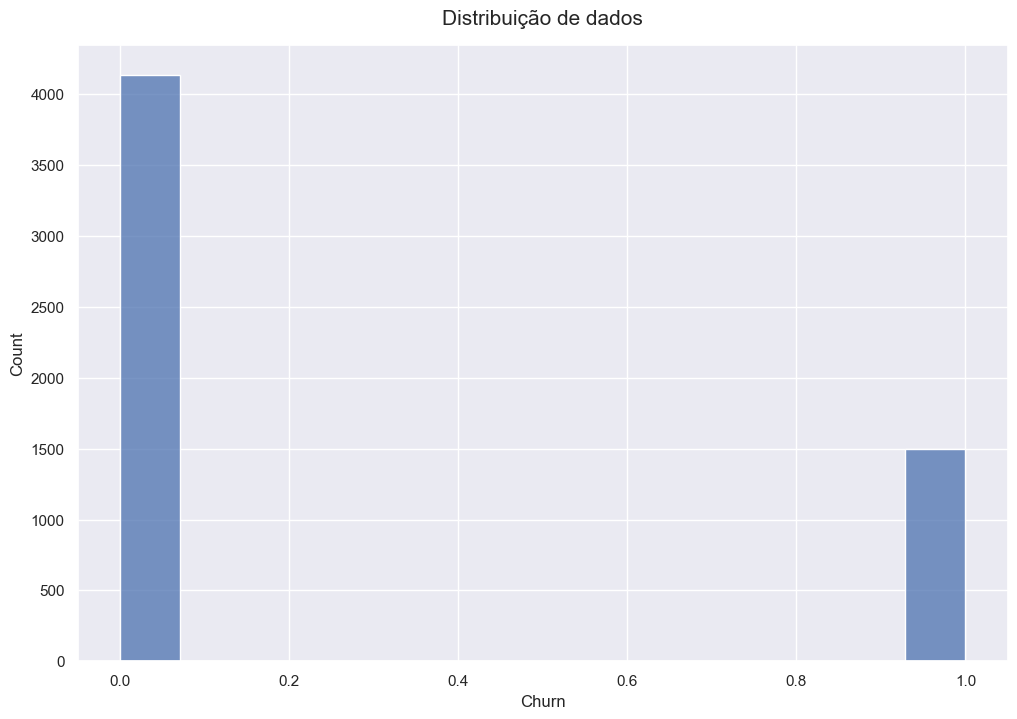

In [42]:
sns.histplot(data['Churn'])
plt.title('Distribuição de dados',size=15,pad=15);

# 3. Preparação dos Dados

# 3.1 Split dos Dados


In [43]:
X = data.drop(columns=['id', 'Churn'])
y = data.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [44]:
num_attributes = X_train.select_dtypes(include=['int32', 'int8', 'int64', 'float64', 'float32', 'float16'])
cat_attributes = X_train.select_dtypes(exclude=['int32', 'int8', 'int64', 'float64', 'float32', 'float16', 'datetime64[ns]'])

## 3.2 Pipeline de Imputações de Dados e Encoding (variáveis categóricas)

In [45]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
    # ('imputer', SimpleImputer(strategy='mean'))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

# 4. Modelo de Machine Learning

# 4.1 Feature Selection

Quantidade de features no conjunto de dados inicial: 19
Quantidade de features selecionadas: 19


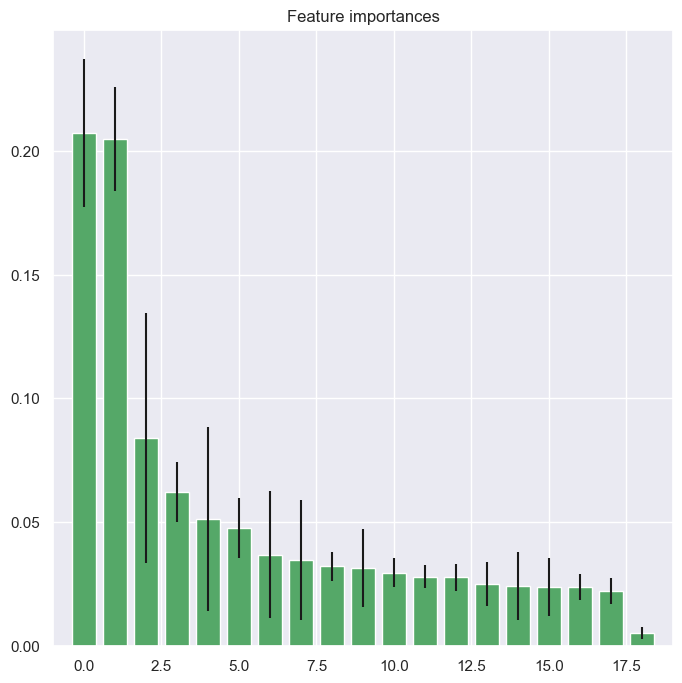

In [46]:
pipe_feature_importances = Pipeline([
                            ('preprocessor', preprocessor),
                            ('model', RandomForestClassifier())
])

pipe_feature_importances.fit(X_train, y_train)

importances = pipe_feature_importances['model'].feature_importances_
std         = np.std([tree.feature_importances_ for tree in pipe_feature_importances['model'].estimators_],
             axis=0)
indices     = np.argsort(importances)[::-1]

indices_selected_features=[]

for f in range(X_train.shape[1]):
    if importances[indices[f]] > 0: 
        indices_selected_features.append(indices[f])

print('Quantidade de features no conjunto de dados inicial: {}'.format(X_train.shape[1]))
print('Quantidade de features selecionadas: {}'.format(len(indices_selected_features)))

# Plot the feature importances of the forest
plt.figure(1, figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
# plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [47]:
# Lista das 10 Features mais importantes
indices_selected_features_top10 = indices_selected_features[:10]

# Exibir as 10 features mais importantes
print(X_train.columns[indices_selected_features_top10].to_list())

['MonthlyCharges', 'TotalCharges', 'StreamingTV', 'Contract', 'MultipleLines', 'PaperlessBilling', 'OnlineBackup', 'PhoneService', 'gender', 'InternetService']


In [48]:
# Atualização do X_train e X_test com base em todas as features selecionadas
X_train = X_train[X_train.columns[indices_selected_features]]
X_test  = X_test[X_test.columns[indices_selected_features]]

In [49]:
num_attributes = X_train.select_dtypes(include=['int32', 'int8', 'int64', 'float64', 'float32', 'float16'])
cat_attributes = X_train.select_dtypes(exclude=['int32', 'int8', 'int64', 'float64', 'float32', 'float16', 'datetime64[ns]'])

# 4.3 Seleção do Modelo de Machine Learning

Modelos testados:

* LogisticRegression();
* RandomForestClassifier();
* XGBClassifier();
* lgb.LGBMClassifier();
* CatBoostClassifier()


In [50]:
classifiers = [
    LogisticRegression(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    XGBClassifier(),
    lgb.LGBMClassifier(class_weight='balanced'),
    CatBoostClassifier(verbose=False)
]

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
    # ('imputer', SimpleImputer(strategy='mean'))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

results = []
for classifier in classifiers:
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
    pipe.fit(X_train, y_train)
    ypred = pipe.predict(X_test)
    y_pred_prob = pipe.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test,y_pred_prob)
    results.append(roc_auc)
    print(classifier)
    print("model roc_auc_score: %.4f" % roc_auc)
    print("model classification report")
    print(classification_report(y_test, ypred))

LogisticRegression(class_weight='balanced')
model roc_auc_score: 0.8780
model classification report
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       827
           1       0.56      0.84      0.68       300

    accuracy                           0.78      1127
   macro avg       0.75      0.80      0.76      1127
weighted avg       0.83      0.78      0.80      1127

RandomForestClassifier(class_weight='balanced')
model roc_auc_score: 0.8508
model classification report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       827
           1       0.65      0.48      0.55       300

    accuracy                           0.79      1127
   macro avg       0.74      0.69      0.71      1127
weighted avg       0.78      0.79      0.78      1127

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
   

In [51]:
# Comparação entre a métrica ROC-AUC para os diversos modelos
df_roc_auc = pd.DataFrame(results,index=['LogisticRegression','Random Forest','XGBoost','LightGBM','Catboost'],columns=['ROC-AUC']).sort_values(by='ROC-AUC',ascending=False)
df_roc_auc

,ROC-AUC
LogisticRegression,0.877965
Catboost,0.867763
LightGBM,0.858025
Random Forest,0.850838
XGBoost,0.841024


In [52]:
# Exportando imagem 
dfi.export(df_roc_auc, 'dataframe_roc_auc_churn.png')

## 4.4 Tunagem do Modelo

In [53]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
    # ('imputer', SimpleImputer(strategy='mean'))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

# classifier = CatBoostClassifier(verbose=False)
classifier = LogisticRegression(class_weight='balanced')

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
distributions = [{
    'classifier__penalty' : ['l1','l2','None'],
    'classifier__C' : np.logspace(-4, 4, 50)
    }]
clf = GridSearchCV(pipe, distributions, cv = 5, verbose=False, n_jobs=-1, scoring='roc_auc')

best_clf = clf.fit(X_train, y_train)

ypred = best_clf.predict(X_test)

y_pred_prob = best_clf.predict_proba(X_test)[:,1]
print(classifier)
print("model roc_auc_score: %.4f" % roc_auc_score(y_test,y_pred_prob))
print("model classification report")
print(classification_report(y_test, ypred))

LogisticRegression(class_weight='balanced')
model roc_auc_score: 0.8780
model classification report
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       827
           1       0.56      0.85      0.68       300

    accuracy                           0.79      1127
   macro avg       0.75      0.80      0.76      1127
weighted avg       0.83      0.79      0.80      1127



# 5. Avaliando os casos de Churn por Faixas de Score

In [54]:
# df corresponde à tabela analítica de modelagem com o score (predict proba) como uma das colunas
df              = X_test.copy()
df['Target']    = y_test
df['Score']     = y_pred_prob

In [55]:
# Função que cria a divisão por faixas de score
def RankScore(input_score_df,nm_score,targetname,bins):
    input_score_df['score'] = input_score_df[nm_score]
    input_score_df['rank']  = pd.cut(input_score_df[nm_score],bins,labels=False)
    df1 =input_score_df.groupby('rank').agg({targetname: np.mean, 'rank': np.size})
    df1['id_ranks'] = df1.index
    df1['tx_evento'] = df1[targetname]
    df1['qt_rank'] = df1['rank']
    df1 = df1.drop(['rank',targetname],axis=1)
    df1 = df1.reset_index()
    df_ord_score = df1.drop(['rank'],axis=1)
    return df_ord_score

In [56]:
df_rank = RankScore(df,'Score','Target',bins=8)

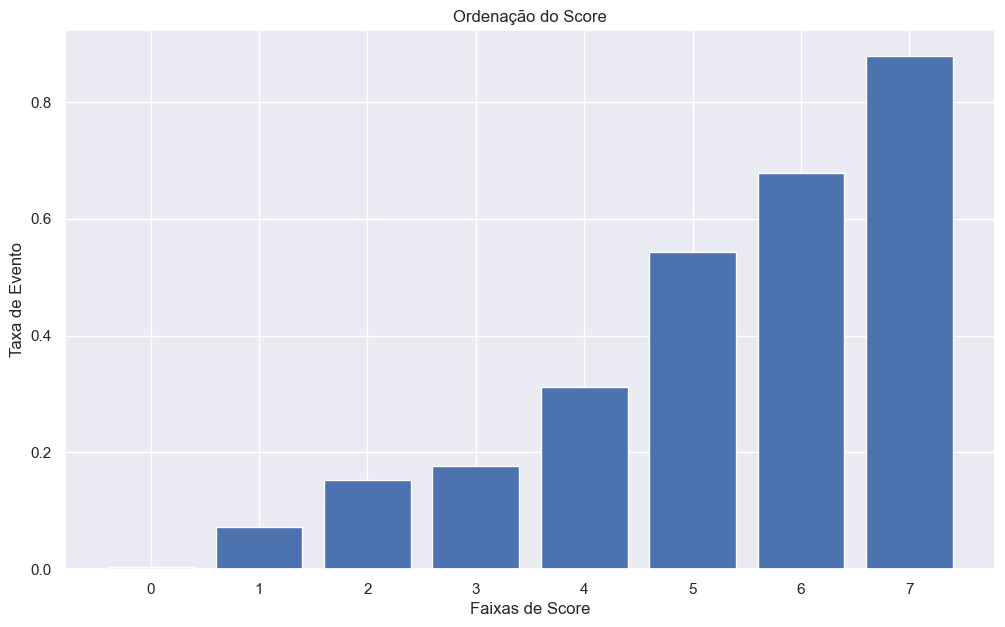

In [57]:
# Plotando gráfico par visualizar o percentual de Churn por faixa de Score
height = df_rank.tx_evento
bars   = df_rank.id_ranks
y_pos  = np.arange(len(bars))

fig = plt.figure(figsize=(12,7))
plt.rcParams.update({'font.size':15})

plt.bar(y_pos,height)
plt.xticks(y_pos,bars)
plt.ylabel('Taxa de Evento')
plt.xlabel('Faixas de Score')
plt.title('Ordenação do Score')

plt.show()

fig.savefig('churn_score.png');

# 6. Exportando modelo para Deploy

In [58]:
# ----------------------- Exportando o modelo com melhor resultado ----------------------- #

# Exportando o modelo final para implantação
import pickle

pickle.dump(best_clf, open('./models/pipe.pkl', 'wb'))